# Motor Repertoire Map (State-Space Expansion)

This notebook compares two time points (e.g., T1 and T3) for the same subject using Principal Component Analysis (PCA) to reduce complex multi-joint movements into two main dimensions and Convex Hull geometry to calculate the "surface area" of the subject's movement repertoire.

**Goal:** Quantify how the movement repertoire expands between baseline (T1) and post-intervention (T3) measurements.

## Step 1: Path Setup and Library Imports

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.spatial import ConvexHull

# Set up project paths
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(PROJECT_ROOT, 'src'))

# Import configuration
from config import CONFIG

# Define derivatives directory
DERIV_DIR = os.path.join(PROJECT_ROOT, CONFIG['derivatives_dir'], "step_06_kinematics")

print(f"Project root: {PROJECT_ROOT}")
print(f"Derivatives directory: {DERIV_DIR}")
print(f"Directory exists: {os.path.exists(DERIV_DIR)}")

Project root: /Users/drorhazan/Documents/untitled folder/Gaga-mocap-Kinematics
Derivatives directory: /Users/drorhazan/Documents/untitled folder/Gaga-mocap-Kinematics/derivatives/step_06_kinematics
Directory exists: True


## Step 2: Data Loading and Feature Selection

In [2]:
# Configuration - choose files to compare by filename patterns
# Option 1: Direct file specification (most flexible)
baseline_filename = "734_T1_P2_R1_Take 2025-12-01 02.28.24 PM__kinematics.parquet"
post_intervention_filename = "734_T3_P2_R2_Take 2025-12-30 04.12.54 PM_005__kinematics.parquet"  # Change to actual T3 file

# Option 2: Pattern-based selection (alternative approach)
# baseline_pattern = "734_T1_*_kinematics.parquet"  # Will match first T1 file found
# post_pattern = "734_T3_*_kinematics.parquet"     # Will match first T3 file found

# Construct full file paths
baseline_file = os.path.join(DERIV_DIR, baseline_filename)
post_file = os.path.join(DERIV_DIR, post_intervention_filename)

# Extract metadata from filenames for labeling
def extract_metadata(filename):
    """Extract subject, timepoint, and trial info from filename"""
    parts = filename.replace('_kinematics.parquet', '').split('_')
    return {
        'subject': parts[0],
        'timepoint': parts[1], 
        'trial': f"{parts[2]}_{parts[3]}",
        'timestamp': ' '.join(parts[4:]) if len(parts) > 4 else ''
    }

baseline_meta = extract_metadata(baseline_filename)
post_meta = extract_metadata(post_intervention_filename)

print(f"Baseline file: {baseline_file}")
print(f"Post-intervention file: {post_file}")
print(f"Baseline exists: {os.path.exists(baseline_file)}")
print(f"Post-intervention exists: {os.path.exists(post_file)}")
print(f"\nBaseline metadata: {baseline_meta}")
print(f"Post-intervention metadata: {post_meta}")

# If files don't exist, show available options
if not os.path.exists(baseline_file) or not os.path.exists(post_file):
    print(f"\nAvailable files in {DERIV_DIR}:")
    if os.path.exists(DERIV_DIR):
        for f in sorted(os.listdir(DERIV_DIR)):
            if f.endswith('_kinematics.parquet'):
                print(f"  - {f}")
    else:
        print("  Derivatives directory does not exist")

Baseline file: /Users/drorhazan/Documents/untitled folder/Gaga-mocap-Kinematics/derivatives/step_06_kinematics/734_T1_P2_R1_Take 2025-12-01 02.28.24 PM__kinematics.parquet
Post-intervention file: /Users/drorhazan/Documents/untitled folder/Gaga-mocap-Kinematics/derivatives/step_06_kinematics/734_T3_P2_R2_Take 2025-12-30 04.12.54 PM_005__kinematics.parquet
Baseline exists: True
Post-intervention exists: True

Baseline metadata: {'subject': '734', 'timepoint': 'T1', 'trial': 'P2_R1', 'timestamp': 'Take 2025-12-01 02.28.24 PM '}
Post-intervention metadata: {'subject': '734', 'timepoint': 'T3', 'trial': 'P2_R2', 'timestamp': 'Take 2025-12-30 04.12.54 PM 005 '}


In [3]:
# Load the data
try:
    t1_df = pd.read_parquet(baseline_file)
    t3_df = pd.read_parquet(post_file)
    
    print(f"Baseline data shape: {t1_df.shape}")
    print(f"Post-intervention data shape: {t3_df.shape}")
    print(f"Baseline columns: {list(t1_df.columns)[:10]}...")  # Show first 10 columns
    
except FileNotFoundError as e:
    print(f"Error loading files: {e}")
    print("\nTroubleshooting:")
    print("1. Check that the filenames above match actual files")
    print("2. Verify the step_06_kinematics directory exists and contains parquet files")
    print("3. Run the pipeline to generate kinematics files if missing")
    
    # Show available files for reference
    if os.path.exists(DERIV_DIR):
        print(f"\nAvailable kinematics files:")
        for f in sorted(os.listdir(DERIV_DIR)):
            if f.endswith('_kinematics.parquet'):
                print(f"  - {f}")
    else:
        print(f"\nDirectory {DERIV_DIR} does not exist")

Baseline data shape: (19617, 487)
Post-intervention data shape: (16935, 487)
Baseline columns: ['time_s', 'Pelvis_Global_Orientation (World Space)_X', 'Pelvis_Global_Orientation (World Space)_Y', 'Pelvis_Global_Orientation (World Space)_Z', 'Lumbar_Angle_X', 'Lumbar_Angle_Y', 'Lumbar_Angle_Z', 'Thoracic_Angle_X', 'Thoracic_Angle_Y', 'Thoracic_Angle_Z']...


In [4]:
# Load the data
try:
    t1_df = pd.read_parquet(baseline_file)
    t3_df = pd.read_parquet(post_file)
    
    print(f"Baseline data shape: {t1_df.shape}")
    print(f"Post-intervention data shape: {t3_df.shape}")
    print(f"\nBaseline columns (first 20): {list(t1_df.columns)[:20]}")
    print(f"\nPost-intervention columns (first 20): {list(t3_df.columns)[:20]}")
    
    # Search for position-related columns with different patterns
    print(f"\n=== Column Analysis ===")
    
    # Check for common position column patterns
    patterns = ['__p[xyz]$', '_p[xyz]$', '[xyz]$', 'pos', 'position']
    
    for pattern in patterns:
        t1_cols = t1_df.filter(regex=pattern).columns
        t3_cols = t3_df.filter(regex=pattern).columns
        if len(t1_cols) > 0 or len(t3_cols) > 0:
            print(f"\nPattern '{pattern}' found:")
            print(f"  T1: {len(t1_cols)} columns (first 3: {list(t1_cols)[:3]})")
            print(f"  T3: {len(t3_cols)} columns (first 3: {list(t3_cols)[:3]})")
    
    # Show all column names that contain position-related terms
    print(f"\nAll columns containing position-related terms:")
    all_t1_cols = [col for col in t1_df.columns if any(term in col.lower() for term in ['x', 'y', 'z', 'pos', 'position'])]
    all_t3_cols = [col for col in t3_df.columns if any(term in col.lower() for term in ['x', 'y', 'z', 'pos', 'position'])]
    print(f"T1 position-related columns ({len(all_t1_cols)}): {all_t1_cols[:10]}")
    print(f"T3 position-related columns ({len(all_t3_cols)}): {all_t3_cols[:10]}")
    
except FileNotFoundError as e:
    print(f"Error loading files: {e}")
    print("\nTroubleshooting:")
    print("1. Check that the filenames above match actual files")
    print("2. Verify the step_06_kinematics directory exists and contains parquet files")
    print("3. Run the pipeline to generate kinematics files if missing")
    
    # Show available files for reference
    if os.path.exists(DERIV_DIR):
        print(f"\nAvailable kinematics files:")
        for f in sorted(os.listdir(DERIV_DIR)):
            if f.endswith('_kinematics.parquet'):
                print(f"  - {f}")
    else:
        print(f"\nDirectory {DERIV_DIR} does not exist")

Baseline data shape: (19617, 487)
Post-intervention data shape: (16935, 487)

Baseline columns (first 20): ['time_s', 'Pelvis_Global_Orientation (World Space)_X', 'Pelvis_Global_Orientation (World Space)_Y', 'Pelvis_Global_Orientation (World Space)_Z', 'Lumbar_Angle_X', 'Lumbar_Angle_Y', 'Lumbar_Angle_Z', 'Thoracic_Angle_X', 'Thoracic_Angle_Y', 'Thoracic_Angle_Z', 'Neck_Base_Angle_X', 'Neck_Base_Angle_Y', 'Neck_Base_Angle_Z', 'Head_Angle_X', 'Head_Angle_Y', 'Head_Angle_Z', 'LeftHip_Angle_X', 'LeftHip_Angle_Y', 'LeftHip_Angle_Z', 'LeftKnee_Angle_X']

Post-intervention columns (first 20): ['time_s', 'Pelvis_Global_Orientation (World Space)_X', 'Pelvis_Global_Orientation (World Space)_Y', 'Pelvis_Global_Orientation (World Space)_Z', 'Lumbar_Angle_X', 'Lumbar_Angle_Y', 'Lumbar_Angle_Z', 'Thoracic_Angle_X', 'Thoracic_Angle_Y', 'Thoracic_Angle_Z', 'Neck_Base_Angle_X', 'Neck_Base_Angle_Y', 'Neck_Base_Angle_Z', 'Head_Angle_X', 'Head_Angle_Y', 'Head_Angle_Z', 'LeftHip_Angle_X', 'LeftHip_Angle_Y

In [5]:
# Feature selection - extract joint angle columns for posture-based movement repertoire
def extract_position_features(df):
    """Extract joint angle columns for movement repertoire analysis"""
    # Get joint angle columns (exclude orientation and magnitude columns)
    angle_cols = [col for col in df.columns 
                  if 'Angle' in col and 
                  (col.endswith('_X') or col.endswith('_Y') or col.endswith('_Z')) and
                  'Orientation' not in col and
                  'mag' not in col]
    
    print(f"Found {len(angle_cols)} joint angle columns")
    
    if len(angle_cols) > 0:
        print(f"Joint angle columns (first 10): {list(angle_cols[:10])}")
        
        # Group by joint names to show what we're analyzing
        joint_groups = {}
        for col in angle_cols:
            joint = '_'.join(col.split('_')[:-1])  # Remove the _X/_Y/_Z part
            if joint not in joint_groups:
                joint_groups[joint] = []
            joint_groups[joint].append(col)
        
        print(f"Joints included ({len(joint_groups)}): {list(joint_groups.keys())}")
    else:
        print("WARNING: No joint angle columns found!")
        return pd.DataFrame()
    
    # Extract angle data and drop rows with missing markers
    angle_data = df[angle_cols].dropna()
    print(f"Data shape after dropping NaN: {angle_data.shape}")
    
    # Show some statistics
    if not angle_data.empty:
        print(f"Angle range summary (degrees):")
        stats = angle_data.describe()
        print(f"  Min values: {stats.loc['min'].values[:5]}")
        print(f"  Max values: {stats.loc['max'].values[:5]}")
        print(f"  Std values: {stats.loc['std'].values[:5]}")
    
    return angle_data

if 't1_df' in locals() and 't3_df' in locals():
    print("=== Extracting T1 Joint Angle Features ===")
    t1_positions = extract_position_features(t1_df)
    print("\n=== Extracting T3 Joint Angle Features ===")
    t3_positions = extract_position_features(t3_df)
    
    # Check if we have data to proceed
    if t1_positions.empty or t3_positions.empty:
        print("\nERROR: No joint angle data available for analysis!")
    else:
        print(f"\nSUCCESS: Ready for PCA analysis")
        print(f"T1 joint angle data shape: {t1_positions.shape}")
        print(f"T3 joint angle data shape: {t3_positions.shape}")
        print(f"Analyzing {t1_positions.shape[1]} joint angles across {t1_positions.shape[0] + t3_positions.shape[0]} timeframes")
else:
    print("Data not loaded - please check file paths")

=== Extracting T1 Joint Angle Features ===
Found 60 joint angle columns
Joint angle columns (first 10): ['Lumbar_Angle_X', 'Lumbar_Angle_Y', 'Lumbar_Angle_Z', 'Thoracic_Angle_X', 'Thoracic_Angle_Y', 'Thoracic_Angle_Z', 'Neck_Base_Angle_X', 'Neck_Base_Angle_Y', 'Neck_Base_Angle_Z', 'Head_Angle_X']
Joints included (20): ['Lumbar_Angle', 'Thoracic_Angle', 'Neck_Base_Angle', 'Head_Angle', 'LeftHip_Angle', 'LeftKnee_Angle', 'LeftAnkle_Angle', 'LeftToe_Angle', 'RightHip_Angle', 'RightKnee_Angle', 'RightAnkle_Angle', 'RightToe_Angle', 'LeftClavicle_Angle', 'LeftShoulder_Joint_Angle', 'LeftElbow_Angle', 'LeftWrist_Angle', 'RightClavicle_Angle', 'RightShoulder_Joint_Angle', 'RightElbow_Angle', 'RightWrist_Angle']
Data shape after dropping NaN: (19617, 60)
Angle range summary (degrees):
  Min values: [ -0.44629578 -14.07630694  -1.94477653  -0.40211773 -14.05741312]
  Max values: [ 8.86342055 15.99246299  1.58929034  8.90778876 16.01286344]
  Std values: [1.56086371 3.79406337 0.71239633 1.55016

In [6]:
# Combine data for consistent scaling and PCA
if 't1_positions' in locals() and 't3_positions' in locals():
    # Concatenate the two datasets
    combined_data = pd.concat([t1_positions, t3_positions], ignore_index=True)
    print(f"Combined data shape: {combined_data.shape}")
    
    # Standardize the data
    scaler = StandardScaler()
    combined_scaled = scaler.fit_transform(combined_data)
    print(f"Scaled data shape: {combined_scaled.shape}")
    
    # Apply PCA with sufficient components for complexity analysis
    # Use min(20, n_features) to capture full complexity while avoiding overfitting
    n_components = min(20, combined_data.shape[1])
    pca = PCA(n_components=n_components)
    combined_pca = pca.fit_transform(combined_scaled)
    
    # Split back into T1 and T3 (using first 2 components for visualization)
    n_t1 = len(t1_positions)
    t1_pca = combined_pca[:n_t1, :2]  # First 2 components for hull analysis
    t3_pca = combined_pca[n_t1:, :2]  # First 2 components for hull analysis
    
    print(f"T1 PCA shape (2D): {t1_pca.shape}")
    print(f"T3 PCA shape (2D): {t3_pca.shape}")
    print(f"Full PCA shape: {combined_pca.shape}")
    print(f"Total components fitted: {n_components}")
    print(f"PC1 explains {pca.explained_variance_ratio_[0]*100:.1f}% of variance")
    print(f"PC2 explains {pca.explained_variance_ratio_[1]*100:.1f}% of variance")
    print(f"First 5 components explain {sum(pca.explained_variance_ratio_[:5])*100:.1f}% of variance")
else:
    print("Position data not available")

Combined data shape: (36552, 60)
Scaled data shape: (36552, 60)
T1 PCA shape (2D): (19617, 2)
T3 PCA shape (2D): (16935, 2)
Full PCA shape: (36552, 20)
Total components fitted: 20
PC1 explains 12.4% of variance
PC2 explains 11.1% of variance
First 5 components explain 44.3% of variance


## Step 3.5: Movement Complexity Analysis (Motor Degrees of Freedom)

This analysis measures how many independent "building blocks" of motion are needed to describe the subject's movement. 

**High Complexity**: Many components needed → rich, multi-dimensional, non-repetitive movement (hallmark of Gaga)  
**Learning & Plasticity**: More components at T3 than T1 → developed new degrees of freedom

In [ ]:
# Calculate complexity for each time point separately
def analyze_complexity(data, label):
    """Analyze movement complexity for a single dataset"""
    # Standardize the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    
    # Apply PCA with sufficient components
    n_components = min(20, data.shape[1])
    pca_single = PCA(n_components=n_components)
    pca_single.fit(scaled_data)
    
    # Calculate cumulative variance
    cumulative_variance = np.cumsum(pca_single.explained_variance_ratio_)
    
    # Find components needed for thresholds
    thresholds = [0.70, 0.80, 0.90]
    results = {}
    
    for t in thresholds:
        indices = np.where(cumulative_variance >= t)[0]
        if len(indices) > 0:
            results[t] = indices[0] + 1
        else:
            results[t] = len(cumulative_variance)
    
    return {
        'cumulative_variance': cumulative_variance,
        'pca': pca_single,
        'results': results,
        'label': label
    }

# Analyze T1 and T3 separately
if 't1_positions' in locals() and 't3_positions' in locals():
    t1_complexity = analyze_complexity(t1_positions, f"{baseline_meta['timepoint']} (Baseline)")
    t3_complexity = analyze_complexity(t3_positions, f"{post_meta['timepoint']} (Post-Gaga)")
    
    print("--- T1 Movement Complexity ---")
    for t, n in t1_complexity['results'].items():
        print(f"T1: {n} components for {t*100:.0f}% variance")
    
    print("\n--- T3 Movement Complexity ---")
    for t, n in t3_complexity['results'].items():
        print(f"T3: {n} components for {t*100:.0f}% variance")
    
    print("\n--- Comparison ---")
    for t in thresholds:
        t1_n = t1_complexity['results'][t]
        t3_n = t3_complexity['results'][t]
        change = t3_n - t1_n
        change_pct = (change / t1_n * 100) if t1_n > 0 else 0
        print(f"{t*100:.0f}% threshold: T1={t1_n}, T3={t3_n} (Change: {change:+d}, {change_pct:+.1f}%)")
else:
    print("Position data not available for complexity analysis")

Total variance explained by all 20 components: 81.1%
Cumulative variance values: [0.12377731 0.23527373 0.31456703 0.38027507 0.44281323 0.4959688
 0.53989793 0.57477682 0.60691646 0.63230774]
✓ 70% threshold reached at component 14
✓ 80% threshold reached at component 20
✗ 90% threshold NOT reached - using all 20 components

--- Movement Complexity Report ---
To explain 70% of the movement, we need 14 Principal Components.
To explain 80% of the movement, we need 20 Principal Components.
To explain 90% of the movement, we need ALL 20 components (only 81.1% achieved)


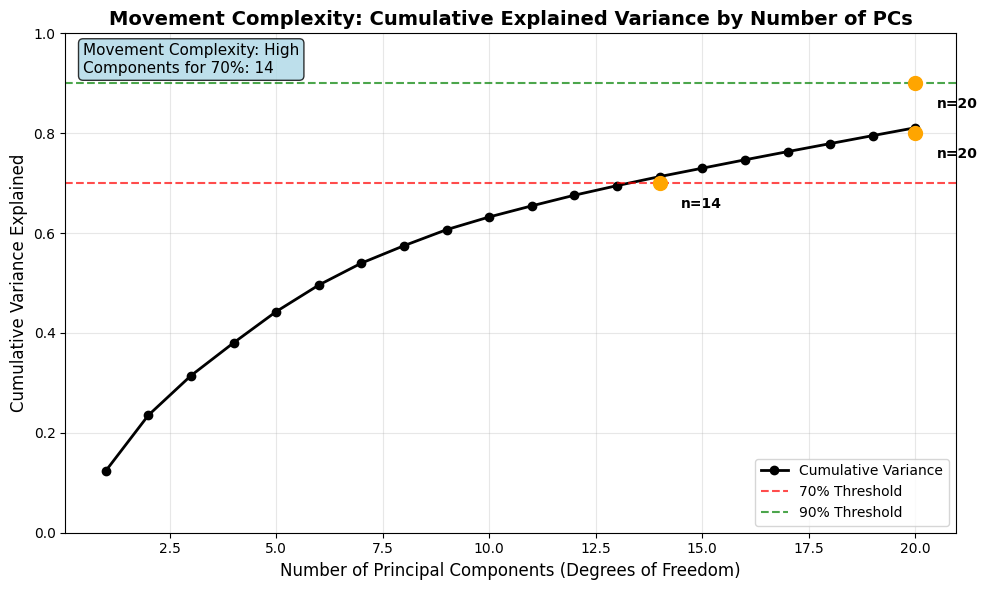

Complexity plot saved to: /Users/drorhazan/Documents/untitled folder/Gaga-mocap-Kinematics/analysis/step_06_plots/734_T1_vs_T3_movement_complexity.png


<Figure size 640x480 with 0 Axes>

In [ ]:
# Visualization - Comparative Scree Plot for T1 vs T3
if 't1_complexity' in locals() and 't3_complexity' in locals():
    plt.figure(figsize=(12, 7))
    
    # Plot cumulative variance for both time points
    plt.plot(range(1, len(t1_complexity['cumulative_variance']) + 1), 
             t1_complexity['cumulative_variance'], 'o-', 
             color='blue', linewidth=2, markersize=6, 
             label=f"T1 (Baseline)")
    
    plt.plot(range(1, len(t3_complexity['cumulative_variance']) + 1), 
             t3_complexity['cumulative_variance'], 's-', 
             color='orange', linewidth=2, markersize=6, 
             label=f"T3 (Post-Gaga)")
    
    # Add threshold lines
    plt.axhline(y=0.7, color='red', linestyle='--', alpha=0.7, label='70% Threshold')
    plt.axhline(y=0.9, color='green', linestyle='--', alpha=0.7, label='90% Threshold')
    
    # Mark threshold crossing points for T1
    for t, n in t1_complexity['results'].items():
        if n <= len(t1_complexity['cumulative_variance']):
            plt.plot(n, t, 'o', markersize=10, color='darkblue')
            plt.annotate(f'T1: {n}', (n, t), xytext=(n+0.3, t-0.03), 
                       fontsize=9, color='darkblue', fontweight='bold')
    
    # Mark threshold crossing points for T3
    for t, n in t3_complexity['results'].items():
        if n <= len(t3_complexity['cumulative_variance']):
            plt.plot(n, t, 's', markersize=10, color='darkorange')
            plt.annotate(f'T3: {n}', (n, t), xytext=(n+0.3, t+0.02), 
                       fontsize=9, color='darkorange', fontweight='bold')
    
    # Formatting
    plt.title(f'Movement Complexity Comparison: {baseline_meta["subject"]} - T1 vs T3', 
              fontsize=14, fontweight='bold')
    plt.xlabel('Number of Principal Components (Degrees of Freedom)', fontsize=12)
    plt.ylabel('Cumulative Variance Explained', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.ylim(0, 1.0)
    
    # Add comparison text
    t1_70 = t1_complexity['results'][0.70]
    t3_70 = t3_complexity['results'][0.70]
    change = t3_70 - t1_70
    complexity_change = "Increased" if change > 0 else "Decreased" if change < 0 else "Same"
    
    comparison_text = f'Complexity Change: {complexity_change}\n70% Threshold: T1={t1_70}, T3={t3_70} (Δ{change:+d})'
    plt.text(0.02, 0.98, comparison_text, 
             transform=plt.gca().transAxes, fontsize=11, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # Save the comparison plot
    output_dir = os.path.join(PROJECT_ROOT, 'analysis', 'step_06_plots')
    os.makedirs(output_dir, exist_ok=True)
    comparison_file = os.path.join(output_dir, f'{baseline_meta["subject"]}_{baseline_meta["timepoint"]}_vs_{post_meta["timepoint"]}_complexity_comparison.png')
    plt.savefig(comparison_file, dpi=300, bbox_inches='tight')
    print(f"Complexity comparison plot saved to: {comparison_file}")
else:
    print("Complexity data not available for visualization")

### What does this graph tell us?

**Movement Complexity**: If many components (e.g., more than 10) are required to reach the 70% threshold, it indicates a rich, multi-dimensional, and non-repetitive movement pattern.

**System Efficiency**: If T3 requires more components than T1 to explain the same amount of data, it serves as evidence that the subject has unlocked new "degrees of freedom," making their movement more complex and versatile.

**Clinical Interpretation**:
- **Low Complexity (≤5 components for 70%)**: Movements are simple, repetitive, habitual
- **Moderate Complexity (6-10 components for 70%)**: Some variation in movement patterns  
- **High Complexity (>10 components for 70%)**: Rich, expressive, non-habitual movement (Gaga-like)

## Step 4: Calculating the Repertoire Area (Convex Hull)

In [9]:
# Calculate convex hull areas
if 't1_pca' in locals() and 't3_pca' in locals():
    # Generate convex hulls
    t1_hull = ConvexHull(t1_pca)
    t3_hull = ConvexHull(t3_pca)
    
    # Calculate areas (in 2D, volume represents area)
    t1_area = t1_hull.volume
    t3_area = t3_hull.volume
    
    # Calculate expansion percentage
    expansion_percentage = (t3_area / t1_area - 1) * 100
    
    print(f"T1 repertoire area: {t1_area:.4f}")
    print(f"T3 repertoire area: {t3_area:.4f}")
    print(f"Expansion: {expansion_percentage:.2f}%")
    
    # Store results for visualization
    results = {
        't1_pca': t1_pca,
        't3_pca': t3_pca,
        't1_hull': t1_hull,
        't3_hull': t3_hull,
        't1_area': t1_area,
        't3_area': t3_area,
        'expansion_percentage': expansion_percentage,
        'pca': pca
    }
else:
    print("PCA data not available")

T1 repertoire area: 65.5435
T3 repertoire area: 192.2217
Expansion: 193.27%


## Step 5: High-Impact Visualization

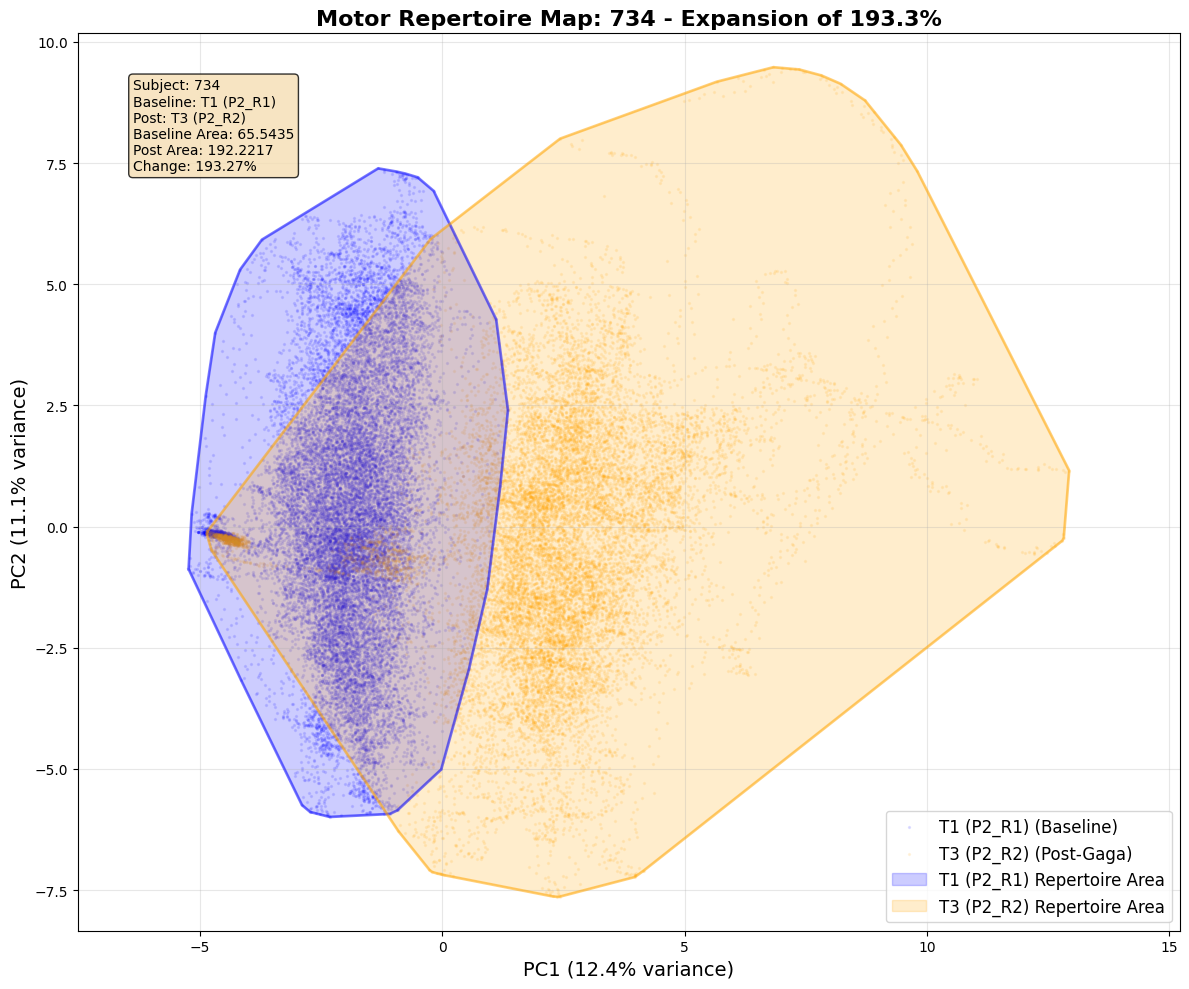

Plot saved to: /Users/drorhazan/Documents/untitled folder/Gaga-mocap-Kinematics/analysis/step_06_plots/734_T1_vs_T3_P2_R1_motor_repertoire_map.png


<Figure size 640x480 with 0 Axes>

In [10]:
# Create report-ready visualization
if 'results' in locals():
    # Set up the plot
    plt.figure(figsize=(12, 10))
    
    # Use extracted metadata for labels
    baseline_label = f"{baseline_meta['timepoint']} ({baseline_meta['trial']})"
    post_label = f"{post_meta['timepoint']} ({post_meta['trial']})"
    
    # Create scatter plots with heat cloud effect
    plt.scatter(results['t1_pca'][:, 0], results['t1_pca'][:, 1], 
                alpha=0.1, s=2, color='blue', label=f'{baseline_label} (Baseline)')
    plt.scatter(results['t3_pca'][:, 0], results['t3_pca'][:, 1], 
                alpha=0.1, s=2, color='orange', label=f'{post_label} (Post-Gaga)')
    
    # Plot convex hull areas with transparency
    # T1 hull (blue)
    t1_hull_points = results['t1_pca'][results['t1_hull'].vertices]
    t1_hull_closed = np.vstack([t1_hull_points, t1_hull_points[0]])  # Close the hull
    plt.fill(t1_hull_closed[:, 0], t1_hull_closed[:, 1], 
             color='blue', alpha=0.2, label=f'{baseline_label} Repertoire Area')
    plt.plot(t1_hull_closed[:, 0], t1_hull_closed[:, 1], 
             color='blue', alpha=0.5, linewidth=2)
    
    # T3 hull (orange)
    t3_hull_points = results['t3_pca'][results['t3_hull'].vertices]
    t3_hull_closed = np.vstack([t3_hull_points, t3_hull_points[0]])  # Close the hull
    plt.fill(t3_hull_closed[:, 0], t3_hull_closed[:, 1], 
             color='orange', alpha=0.2, label=f'{post_label} Repertoire Area')
    plt.plot(t3_hull_closed[:, 0], t3_hull_closed[:, 1], 
             color='orange', alpha=0.5, linewidth=2)
    
    # Set labels with explained variance
    pc1_var = results['pca'].explained_variance_ratio_[0] * 100
    pc2_var = results['pca'].explained_variance_ratio_[1] * 100
    plt.xlabel(f'PC1 ({pc1_var:.1f}% variance)', fontsize=14)
    plt.ylabel(f'PC2 ({pc2_var:.1f}% variance)', fontsize=14)
    
    # Create title with expansion percentage
    expansion_dir = "Expansion" if results['expansion_percentage'] > 0 else "Contraction"
    plt.title(f'Motor Repertoire Map: {baseline_meta["subject"]} - {expansion_dir} of {abs(results["expansion_percentage"]):.1f}%', 
              fontsize=16, fontweight='bold')
    
    # Add legend and grid
    plt.legend(fontsize=12, loc='best')
    plt.grid(True, alpha=0.3)
    
    # Set equal aspect ratio for accurate area representation
    plt.axis('equal')
    
    # Add text box with summary statistics
    textstr = f'\n'.join([
        f'Subject: {baseline_meta["subject"]}',
        f'Baseline: {baseline_meta["timepoint"]} ({baseline_meta["trial"]})',
        f'Post: {post_meta["timepoint"]} ({post_meta["trial"]})',
        f'Baseline Area: {results["t1_area"]:.4f}',
        f'Post Area: {results["t3_area"]:.4f}',
        f'Change: {results["expansion_percentage"]:.2f}%'
    ])
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=10,
             verticalalignment='top', bbox=props)
    
    plt.tight_layout()
    plt.show()
    
    # Save the figure with descriptive filename
    output_dir = os.path.join(PROJECT_ROOT, 'analysis', 'step_06_plots')
    os.makedirs(output_dir, exist_ok=True)
    output_filename = f'{baseline_meta["subject"]}_{baseline_meta["timepoint"]}_vs_{post_meta["timepoint"]}_{baseline_meta["trial"]}_motor_repertoire_map.png'
    output_file = os.path.join(output_dir, output_filename)
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"Plot saved to: {output_file}")
else:
    print("Results not available for visualization")

## Summary and Interpretation

This analysis provides a quantitative measure of how the subject's movement repertoire changes between two time points:

- **Positive expansion percentage** indicates the subject has a broader movement repertoire post-intervention
- **Negative expansion percentage** indicates contraction of the movement repertoire
- **The convex hull area** represents the total "movement space" explored by the subject
- **PCA components** show the primary dimensions of movement variation

This visualization is suitable for:
- Donor reports and presentations
- Scientific publications
- Clinical progress monitoring
- Research outcome documentation